# Common

In [171]:
# print_function for compatibility with Python 3
from __future__ import print_function
print('print function is ready to serve')

# NumPy for numerical computing
import numpy as np
np.random.seed(123)
import random
random.seed(123)

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_column', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline

import tensorflow as tf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD, Adam

import os
import gc
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

print function is ready to serve


In [172]:
# PLANET_KAGGLE_ROOT = '/Users/jiayou/Documents/Kaggle Data/Amazon'
PLANET_KAGGLE_ROOT = '/data/planet-data/'

N_TAGS = 17
N_TRAIN = 40479
N_USE = 32000
# N_USE = 20
N_TEST_T = 40669
N_TEST_F = 20522
N_TEST = N_TEST_T + N_TEST_F

def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.tif vs. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            print('Found image {}'.format(path))
            return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))

def load_train_image(n, tif=False, dbg=False):
    if tif:
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2', 'train_{}.tif'.format(n)))
    else:
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg', 'train_{}.jpg'.format(n)))
    if os.path.exists(path):
        img = io.imread(path)
#         if dbg:
#             plt.figure()
#             plt.imshow(img)
        return img
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))

def load_test_image(n):
    path = None
    if n < N_TEST_T:
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, 'test-jpg', 'test_{}.jpg'.format(n)))
    else:
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, 'test-jpg-additional', 'file_{}.jpg'.format(n - N_TEST_T)))
    if os.path.exists(path):
        return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))

    
calib_params = np.array(
    [[ 4953.06200497,  4238.24180873,  3039.04404623,  6387.04264221],
     [ 1692.87422811,  1528.24629706,  1576.04566834,  1804.99976545]]
)
    
def preprocess_image(img):
    img = img.astype('float16')
#     img = downscale_local_mean(img, (4, 4, 1))

    if img.shape[2] == 3:
        # jpg
        img = img / 255 - 0.5
    else:
        # tif
        for i in range(4):
            img[:,:,i] = (img[:,:,i] - calib_params[0,i]) / 1500
        
    return img

In [173]:
# img = load_train_image(1)
# plt.imshow(img)
# img.shape

In [174]:
train_labels = pd.read_csv(os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv'))
train_labels

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [175]:
train_labels = pd.read_csv(os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv'))

label_list = []
for tag_str in train_labels.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

label_map = {}
for i in range(len(label_list)):
    label_map[label_list[i]] = i
label_idx = {v: k for k, v in label_map.items()}

weather_labels = [0, 3, 9, 10]
weather_labels = []

thres = [0.24, 0.22, 0.25, 0.23, 0.26, 0.19, 0.24, 0.23, 0.1, 0.16, 0.14,
         0.2, 0.17, 0.33, 0.04, 0.12, 0.07]

def pred_to_tags(y):
    maxw = 0
    w = 3
    tags = []
    for i in range(N_TAGS):
        tag = label_idx[i]
        if i in weather_labels:
            if y[i] > maxw:
                maxw = y[i]
                w = i
        else:
            if y[i] >= thres[i]:
                tags.append(tag)
#     tags.append(label_idx[w])
    return ' '.join(tags)

def output(pred):
    result = pd.DataFrame({
        'image_name': 
            ['test_{}'.format(i) for i in range(N_TEST_T)] + ['file_{}'.format(i) for i in range(N_TEST_F)],
        'tags': ['' for i in range(N_TEST)]
    })
    for i in range(len(pred)):
        current_pred = pred[i]
        current_tag = pred_to_tags(current_pred)
        result.iat[i, 1] = current_tag
    return result

label_idx

{0: 'haze',
 1: 'primary',
 2: 'agriculture',
 3: 'clear',
 4: 'water',
 5: 'habitation',
 6: 'road',
 7: 'cultivation',
 8: 'slash_burn',
 9: 'cloudy',
 10: 'partly_cloudy',
 11: 'conventional_mine',
 12: 'bare_ground',
 13: 'artisinal_mine',
 14: 'blooming',
 15: 'selective_logging',
 16: 'blow_down'}

In [178]:
def get_training_data(file_ids, tif=False, dbg=False, verbose=False):
    if verbose:
        print('Getting {} training images...'.format(len(file_ids)))
    X_train = np.zeros((len(file_ids), 64, 64, 4 if tif else 3))
    for i in range(len(file_ids)):
        X_train[i,:,:,:] = preprocess_image(load_train_image(file_ids[i], tif=tif, dbg=dbg))
        if verbose and i % 100 == 0:
            print('Got {} images'.format(i+1))
    if verbose:
        print('Done')
    
    y_train = np.array([[0. for i in range(N_TAGS)] for j in file_ids])
    for i in range(len(file_ids)):
        tags = train_labels.tags[file_ids[i]]
        if dbg:
            print(file_ids[i], tags)
        for tag in tags.split(' '):
            if not tag in label_map:
                continue
            y_train[i][label_map[tag]] = 1.
    if dbg:
        print(y_train)
    
    return (X_train, y_train)

def get_test_data(file_ids):
    X_train = np.array([preprocess_image(load_test_image(fname)) for fname in file_ids])
    return X_train

def gen_training_data(batch_size, dbg=False):
    while 1:
        file_ids = np.random.randint(0, N_TRAIN, size=batch_size).tolist()
        for i in range(len(file_ids)):
            if file_ids[i] % 5 == 0:
                file_ids[i] = (file_ids[i] + 1) % N_TRAIN
        file_ids.sort()
        if dbg:
            print('file ids: ', file_ids)
        yield get_training_data(file_ids, dbg)


def gen_validation_data(batch_size):
    while 1:
        file_ids = (np.random.randint(0, int(N_TRAIN / 5), size=batch_size) * 5).tolist()
        file_ids.sort()
        yield get_training_data(file_ids)
        
def gen_test_data(batch_size):
    start = 0
    while start < N_TEST:
        end = min(start + batch_size, N_TEST)
        yield get_test_data(range(start, end))
        start = end

In [228]:
class Data:
    def __init__(self):
        print('Loading data...')
        self.X = [0] * 5
        self.y = [0] * 5
        for i in range(5):
            self.X[i] = np.load('X.{}.npy'.format(i))
            self.y[i] = np.load('y.{}.npy'.format(i))
            print('Loaded fold {}.'.format(i))
            
    def gen_train(self, batch_size, val=0):
        while 1:
            f = val
            while f == val:
                f = random.randint(0, 4)
            yield self.data_from_fold(f, batch_size)
    
    def gen_val(self, batch_size, val=0):
        f = val
        while 1:
            ids = np.random.randint(0, len(self.y[f]), size=batch_size).tolist()
            ids.sort()
            yield (self.X[f][ids,:,:,:], self.y[f][ids,:])
    
    def data_from_fold(self, f, batch_size):
        ids = np.random.randint(0, len(self.y[f]), size=batch_size).tolist()
        ids.sort()
        X = np.zeros((len(ids), 256, 256, 4))
        for i in range(len(ids)):
            X[i,:,:,:] = augment(self.X[f][i,:,:,:].reshape((256, 256, 4))).reshape((1, 256, 256, 4))
        return (X, self.y[f][ids,:])

In [222]:
def augment(im, orient = None):
    if orient is None:
        mirror = random.randint(0, 1)
        rotate = random.randint(0, 3)
    else:
        mirror = orient[0]
        rotate = orient[1]
    im = np.rot90(im, rotate, (0, 1))
    if mirror:
        im = np.flip(im, 1)
    return im

In [227]:
# im = io.imread(os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2', 'train_{}.tif'.format(5)))
# plt.imshow((im[:,:,3]) / 6)
# for i in range(2):
#     for j in range(4):
#         im_new = augment(im, (i, j))
#         plt.figure()
#         plt.imshow((im_new[:,:,3]) / 6)

In [7]:
# g = gen_training_data(2, True)
# t = next(g)

In [8]:
def amazon_score(y_true, y_pred):
    y_true = y_true > 0.2
    y_pred = y_pred > 0.2
    
    y_tp = tf.logical_and(y_true, y_pred)
    y_fn = tf.logical_and(y_true, tf.logical_not(y_pred))
    y_fp = tf.logical_and(tf.logical_not(y_true), y_pred)
    
    tp = tf.reduce_sum(tf.to_float(y_tp))
    fn = tf.reduce_sum(tf.to_float(y_fn))
    fp = tf.reduce_sum(tf.to_float(y_fp))
    
    p = tf.where(tp + fp > 0, tp / (tp + fp), 0)
    r = tf.where(tp + fn > 0, tp / (tp + fn), 1)
    s = tf.where(p + r > 0, 5 * p * r / (4 * p + r), 0)
    
    return s

In [231]:
def new_model():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(64, 64, 4)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(N_TAGS, activation='sigmoid'))

    model.compile(metrics=[amazon_score, 'accuracy'],
                  loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001))
    return model

def load_model(path):
    model = new_model()
    model.load_weights(path)
    return model

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input
from keras.models import Model

import numpy as np

def new_resnet50():
    base_model = ResNet50(weights=None, include_top=False, pooling='avg', input_tensor = Input(shape=(256, 256, 4)))
    
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(17, activation='sigmoid')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
#     for layer in base_model.layers:
#         layer.trainable = False
        
#     for layer in model.layers[-24:]:
#         layer.trainable = True

    model.compile(metrics=[amazon_score, 'accuracy'],
                  loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001))
    return model

In [10]:
def predict(model_path):
    model = load_model(model_path)
    print('Model weights loaded')
    
    pred = None
    cnt = 0
    print('Start predicting..')
    for X_test in gen_test_data(100):
        y_test = model.predict_on_batch(X_test)
        if pred is None:
            pred = y_test
        else:
            pred = np.concatenate((pred, y_test))
        cnt += len(y_test)
        print('Predicted {} images'.format(cnt))
    print('Predicted all {} images'.format(cnt))
            
    print('Saving raw predictions...')
    np.save('raw_pred.npy', pred)
    print('Saved')
    
    result = output(pred)
    print('Saving submission file...')
    result.to_csv('submission.csv', index = None)
    print('Saved')
    return result

# Training

In [ ]:
# def get_cv_data(i):
#     X_train_data = []
#     y_train_data = []
#     for j in range(5):
#         if j != i:
#             X_train_data.append(np.load('X.{}.npy'.format(j)))
#             y_train_data.append(np.load('y.{}.npy'.format(j)))
#         else:
#             X_val = np.load('X.{}.npy'.format(j))
#             y_val = np.load('y.{}.npy'.format(j))
                                
#     X_train = np.concatenate(tuple(X_train_data), axis = 0)
#     y_train = np.concatenate(tuple(y_train_data), axis = 0)
#     return X_train, y_train
    

In [191]:
def train_from_raw():
    X_train, y_train = get_training_data([x for x in range(N_TRAIN) if x % 5 != 0], tif=True, verbose=True)
    gc.collect()
    
    X_val, y_val = get_training_data([x for x in range(N_TRAIN) if x % 5 == 0], tif=True, verbose=True)
    gc.collect()
    
    model = new_model()
    
    h = model.fit(
        X_train, y_train, batch_size=32, verbose=1,
        validation_data=(X_val, y_val),
        epochs=40, initial_epoch=0,
        callbacks=[
            ModelCheckpoint('weights-v7.hdf5', save_best_only=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001, verbose=1)],
    )
    return h

In [230]:
def train():
    d = Data()
    
    m = new_resnet50()
    
    h = model.fit_generator(
        d.gen_train(32), steps_per_epoch=1000, 
        epochs=40, initial_epoch=0,
        validation_data=d.gen_val(100), validation_steps=80,
        callbacks=[
            ModelCheckpoint(
                'weights-v8.hdf5',
                save_best_only=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001, verbose=1)],
        max_q_size=10)
    return h

In [ ]:
train()

In [12]:
# model = new_model()
# model = load_model('/Users/jiayou/weights-v1.02-0.60-0.10.hdf5')
# model = new_resnet50()

In [16]:
# h = model.fit_generator(
#         gen_training_data(30), steps_per_epoch=1000, 
#         epochs=30, initial_epoch=0,
#         validation_data=gen_validation_data(100), validation_steps=80,
#         callbacks=[
#             ModelCheckpoint(
#                 'weights-v5.{epoch:02d}-{val_amazon_score:.2f}-{val_loss:.2f}.hdf5',
#                 save_best_only=True, verbose=1),
#             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1)],
#         max_q_size=10)

# h = model.fit_generator(
#         gen_training_data(1), steps_per_epoch=20,
#         epochs=50, initial_epoch=0,
#         validation_data=gen_validation_data(10), validation_steps=1,
#         callbacks=[ModelCheckpoint('weights-v1.{epoch:02d}-{val_amazon_score:.2f}-{val_loss:.2f}.hdf5')],
#         max_q_size=2)

# h = model.fit(
#     X_train, y_train, batch_size=1, epochs=50, verbose=1,
#     validation_data=(X_train, y_train),
#     callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, verbose=1)]
# )

# h = model.fit(X_train, y_train, batch_size=10, epochs=12, verbose=1, initial_epoch=10)

# Prediction

In [120]:
out = predict('/data/kaggle-planet/weights-v4.24-0.86-0.14.hdf5')

In [47]:
pred = np.load(os.path.join(PLANET_KAGGLE_ROOT, 'preds', 'raw_pred.npy'))
result = output(pred)
result.to_csv(os.path.join(PLANET_KAGGLE_ROOT, 'preds', 'submission-3.csv'), index = None)

In [134]:
def get_training_file_ids(draw_size):
    file_ids = np.random.randint(0, N_TRAIN, size=draw_size).tolist()
    for i in range(len(file_ids)):
        if file_ids[i] % 5 == 0:
            file_ids[i] = (file_ids[i] + 1) % N_TRAIN
    return file_ids

1000

In [136]:
def get_calib_params():
    draw_size = 1000
    file_ids = get_training_file_ids(draw_size)
    ref_color = [[], [], [], []]

    for i in range(draw_size):
        current_im = io.imread(os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2', 'train_{}.tif'.format(file_ids[i])))
        flatten_im = current_im.reshape((-1, 4))
        for j in range(4):
            ref_color[j] += flatten_im[:, j].tolist()

    ref_color = np.array(ref_color)
    ref_param = np.zeros((2, 4))
    ref_param[0,:] = ref_color.mean(axis = 1)
    ref_param[1,:] = ref_color.std(axis = 1)
    return ref_param

array([[ 4953.06200497,  4238.24180873,  3039.04404623,  6387.04264221],
       [ 1692.87422811,  1528.24629706,  1576.04566834,  1804.99976545]])

In [220]:
im = io.imread(os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2', 'train_{}.tif'.format(5)))
im = calib_image(im)
im = im[:3,:3,:]
im_rot = np.rot90(im, 1, (0, 1))
im_mir = np.flip(im_rot, 1)
im_mir
# plt.imshow((im[:,:,3] + 3) / 6)
# plt.hist(np.reshape(im[:,:,0:3], (256*256*3, 1)))

array([[[ 1.4523412 ,  1.82022905,  1.88019753,  0.34845296],
        [ 1.50437021,  1.8614527 ,  1.90796089,  0.40385464],
        [ 1.55957162,  1.90791118,  1.93158937,  0.40884078]],

       [[ 1.48152816,  1.81041384,  1.89614677,  0.30745572],
        [ 1.49294913,  1.84902012,  1.90441668,  0.38834217],
        [ 1.50246668,  1.89286125,  1.89850962,  0.41161087]],

       [[ 1.45424473,  1.80256164,  1.86483908,  0.4121649 ],
        [ 1.51769459,  1.86603308,  1.91032374,  0.44152778],
        [ 1.45424473,  1.86537874,  1.88196969,  0.43875769]]], dtype=float32)

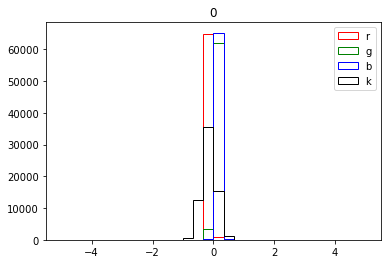

In [167]:
for n in range(1):
    im = io.imread(os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2', 'train_{}.tif'.format(n)))
    im = calib_image(im)
    plt.figure()
    plt.title(n)
    for i, color in enumerate(['r','g','b','k']):
        plt.hist(np.reshape(im[:,:,i], (256*256)), bins=30, label=color, color=color, histtype='step', range=[-5, 5])
    plt.legend()

In [70]:
im = io.imread(os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2', 'train_{}.tif'.format(0)))
im = im.astype('float32')
im = im / 10000 - 0.5
np.save(os.path.join(PLANET_KAGGLE_ROOT, 'train_0.tif.npy'), im)

In [127]:
a = np.zeros((4,2,2,2))
b = a[[1,2],:,:,:]
b[0,0,:,:] = np.array([1,2,3,4]).reshape((2,2))
b

array([[[[ 1.,  2.],
         [ 3.,  4.]],

        [[ 0.,  0.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]]]])

In [132]:
[random.randint(0, 3) for i in range(10)]

[0, 2, 0, 3, 3, 0, 1, 1, 3, 1]